In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import binom

In [2]:
data=pd.read_csv('AdSmartABdata.csv')
wda = data.copy()

## Task 2.1 -Data exploration

The following are bar plots of the relevant columns in the data frame to enable us get a visual understanding of the data. We plot the counts of each unique entry in the column

In [4]:
wda.shape

(8077, 9)

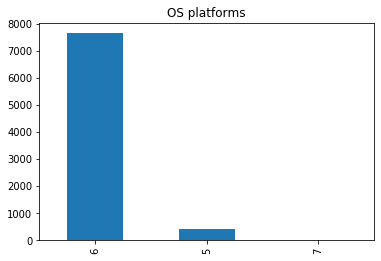

In [5]:
wda['platform_os'].value_counts().plot(kind='bar', title = 'OS platforms')

In [11]:
wda['platform_os'].value_counts()

6    7648
5     428
7       1
Name: platform_os, dtype: int64

* The plot and the values count shows that about 95% of the users use OS type 6

In [6]:
wda['browser'].value_counts()

Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Chrome                           3
Opera Mobile                     3
Pinterest                        3
Android                          1
Firefox Mobile                   1
Opera Mini                       1
Edge Mobile                      1
Puffin                           1
Name: browser, dtype: int64

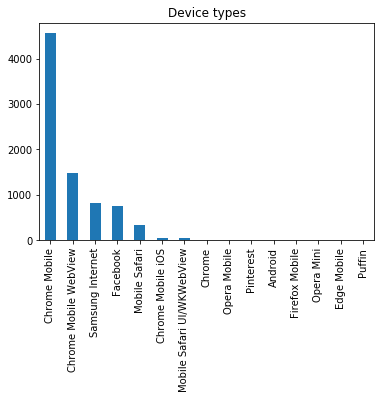

In [7]:
wda['browser'].value_counts().plot(kind='bar',title = 'Device types')

* About 56% of the customers use the mobile version of chrome browser. The web version of the chrome browser is the second widely used browser

In [8]:
wda['hour'].value_counts()

15    1895
8      394
7      381
9      346
10     336
16     335
6      327
14     319
5      302
13     290
11     282
4      281
12     278
18     273
3      266
20     264
17     263
2      230
19     227
1      222
21     206
0      194
22     135
23      31
Name: hour, dtype: int64

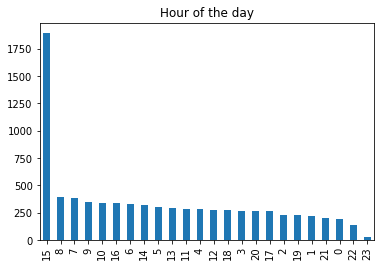

In [9]:
wda['hour'].value_counts().plot(kind='bar',title = 'Hour of the day')

* Most users(23.5%) saw the ads during the 15th hour of the day(3pm). 
* The 23rd hour(11pm) was when very few users(0.38%) viewed the ad 

In [10]:
wda['date'].value_counts()

2020-07-03    2015
2020-07-09    1208
2020-07-08    1198
2020-07-04     903
2020-07-10     893
2020-07-05     890
2020-07-06     490
2020-07-07     480
Name: date, dtype: int64

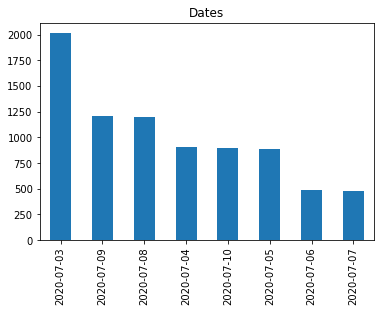

In [11]:
wda['date'].value_counts().plot(kind='bar',title = 'Dates')

* Majority of users (25%) saw the ad on 3rd July 2020
* The ad ran from 3rd July 2020 to 7th Juky 2020 
* There are no unexpected results from some other dates outside of this date range

In [18]:
wda['experiment'].value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

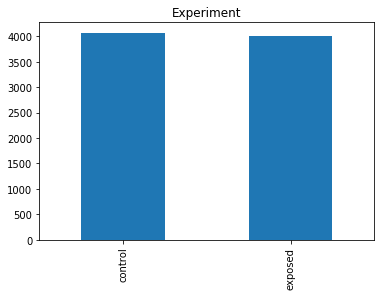

In [19]:
wda['experiment'].value_counts().plot(kind='bar', title = 'Experiment')

4071 of users saw the ad without SmartAd brand i.e 'control' group as against 4006 users who saw the SmartAd branded ad i.e the 'exposed' group

c:\users\programms\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


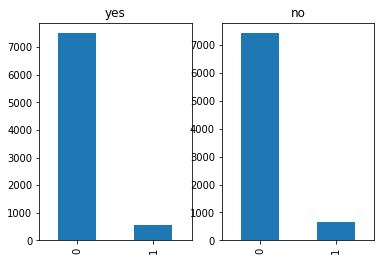

In [12]:
categorical_features = ["yes", "no"]
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(wda[categorical_features]):
    wda[categorical_feature].value_counts().plot("bar", ax=ax[i]).set_title(categorical_feature)
fig.show()

In [23]:
df = wda.copy()

In [24]:
#df.drop(df[df['yes'] == df['no']].index, inplace = True) 

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
auction_id     8077 non-null object
experiment     8077 non-null object
date           8077 non-null object
hour           8077 non-null int64
device_make    8077 non-null object
platform_os    8077 non-null int64
browser        8077 non-null object
yes            8077 non-null int64
no             8077 non-null int64
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [26]:
dff = df.groupby('experiment')

In [27]:
dff.yes.value_counts()

experiment  yes
control     0      3807
            1       264
exposed     0      3698
            1       308
Name: yes, dtype: int64

In [28]:
oddsratio, pvalue = stats.fisher_exact([[322, 349], [264, 308]])
pvalue

0.5309716576383721

* Out 8077 users who saw the ad, only 1243 took the survey. 6834 users did not give any response to the questionaire. 

## Task 2.1 - Preparing to run classic A/B test

* The null hypothesis is that there is no change in a company's brand awareness due to SmartAd's ads while the alternative hypothese is that there is change is a company's brand awareness due to SmartAd's ads. 

* This is tested using the a total of 8077 users divided into 4071 and 4006 for the control and test (exposed) groups respectively. Out of 4071 users who saw the survey for the control, 264 responded 'yes' they are aware of the brand SmartAd. For the test group (exposed), 308 responded 'yes' out of 4006.

* It is important to mention that, not all the users who saw the survey gave a response but for the sake of this experiment, we are consider all who saw the survey as part of the sample population and only those who responded 'yes' as the favorable outcome.
* Since the claim is that, with SmartAd ads, a company awareness can increase by 10 times, we set a Minimum Detectable Effect (MDE) to 10% and a base conversion rate of 20% at a 95% statistical significane. This is inputed to this [online calculator](https://www.optimizely.com/sample-size-calculator/?conversion=25&effect=10&significance=95) to get a minimum sample size of 3,500 to run thi experiment

In [31]:
con = 4071
exp = 4006
f_con, f_exp = 264, 308
p_con, p_exp = f_con / con, f_exp / exp

In [42]:
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    
    scale_one = con_conv * (1-con_conv) * (1/ con_size)
    scale_two = test_conv * (1-test_conv) * (1/ test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale = scale_val)  
    return p_value
get_pvalue(p_con,p_exp,con,exp)

0.03507081594570177

In [49]:
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2-p1)
    bp = (p1+p2) / 2
    
    v1 = p1 * (1-p1)
    v2 = p2 * (1-p2)
    bv = bp * (1-bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    
    power = power_part_one + power_part_two
    
    return (power)
n = con + exp
get_power(n, p_con,p_exp,0.95)

0.8463840204300261

At 95% confidence, a p-value of 0.03 is less than 0.05 so we reject the null hypothesis. The statistical power of 0.85 shows how correct we are in rejecting the null hypothesis.We can therefore conclude that there is change in a company's brand awareness due to SmartAd's ads.